<a href="https://colab.research.google.com/github/LydiaDEdou/projet/blob/main/Sentiment_analysis_with_cnn_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spacy
import nltk
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Télécharger les ressources nécessaires de NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# === Étape 1 : Chargement et nettoyage des données ===
data = pd.read_excel("//content/SentimentAnalysisDataset.xlsx")

In [ ]:
data.head()

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpful...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


In [ ]:
data.shape

(188378, 3)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188378 entries, 0 to 188377
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   conversation_id  188378 non-null  int64 
 1   message          188373 non-null  object
 2   sentiment        188378 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.3+ MB


In [ ]:
data.isnull().sum()

,0
conversation_id,0
message,5
sentiment,0


In [ ]:
df = data.dropna(subset=['message'])
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

,0
conversation_id,0
message,0
sentiment,0


In [ ]:
# Supprimer les valeurs manquantes
data.dropna(subset=['message'], inplace=True)

# Prétraitement du texte
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

##**Distribution of Target Labels**

Analyze class balance:
Visualize the distribution of sentiment labels (positive, negative, neutral) using a bar chart.

**Why it's Important in EDA:**

It allows you to visualize and quantify the imbalance.

It gives insights into whether you need to take steps to correct the imbalance before training the model (e.g., resampling, adjusting class weights).

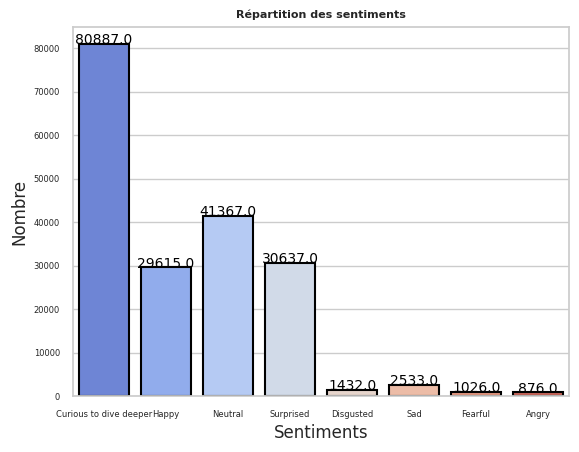

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.countplot(data=df, x='sentiment', palette='coolwarm', edgecolor='black', linewidth=1.5)
plt.title("Répartition des sentiments", fontsize=8, fontweight='bold')
plt.xlabel("Sentiments", fontsize=12)
plt.ylabel("Nombre", fontsize=12)
# Ajuster la taille du texte des classes
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
# Ajouter les annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black')

plt.show()

##**Text Length Analysis**

L'objectif ici est de vérifier la longueur des textes dans votre dataset, afin de mieux comprendre la distribution des textes et d'identifier si certaines longueurs de texte nécessitent un traitement particulier (comme le padding ou la troncation).
Visualize text length distribution using a histogram.
Why important?



*   Long texts might need truncation/padding.
*   Short texts could lack contextual sentiment.

In [ ]:
df['message'] = df['message'].astype(str)
df['sentiment'] = df['sentiment'].astype(str)

In [ ]:
#Nombre de caractères
df['char_length'] = df['message'].apply(lambda x: len(x))
#Nombre de mots
df['text_length'] = df['message'].apply(lambda x: len(x.split()))

**Histogramme de la longueur des textes (en nombre de mots)**

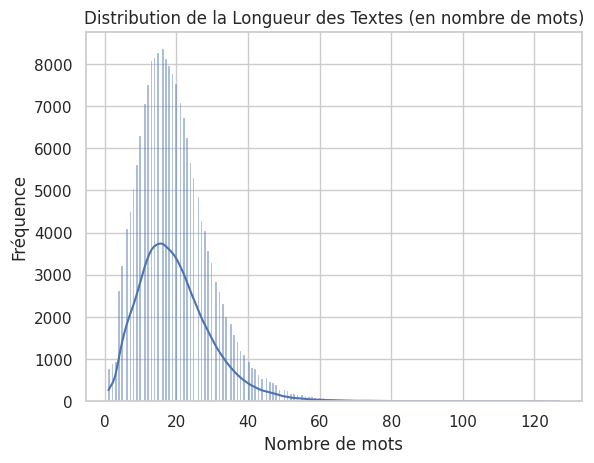

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['text_length'], kde=True)
plt.title('Distribution de la Longueur des Textes (en nombre de mots)')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')
plt.show()

**Histogramme de la longueur des textes (en nombre de caractères)**

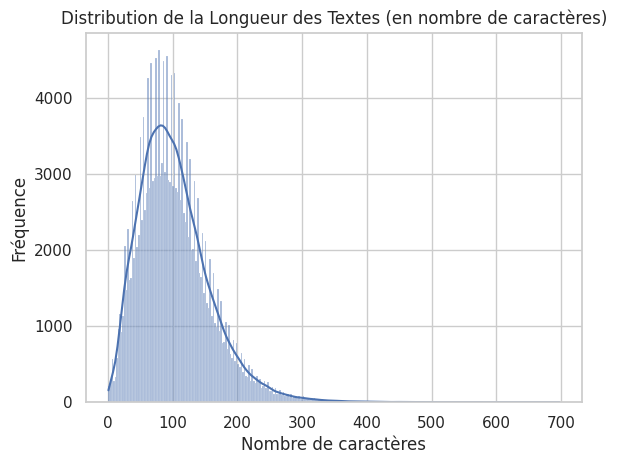

In [ ]:
sns.histplot(df['char_length'], kde=True)
plt.title('Distribution de la Longueur des Textes (en nombre de caractères)')
plt.xlabel('Nombre de caractères')
plt.ylabel('Fréquence')
plt.show()

Lorsque la distribution de la longueur des messages est fortement concentrée du côté gauche (c'est-à-dire qu'il y a beaucoup de textes courts), cela peut indiquer plusieurs choses.


* cela signifie que le dataset contient beaucoup de messages qui ont peu de mots Cela peut être un signe que les textes sont moins informatifs ce qui pourrait nuire à la capacité de votre modèle à capturer des nuances sentimentales.
*   Les textes courts peuvent être plus difficiles à analyser, car ils peuvent manquer de contexte suffisant pour des décisions précises (par exemple, un simple "Bien" peut ne pas donner beaucoup d'indications sur la tonalité générale).

**Analyser les Distributions**


1.  Utiliser des mesures statistiques
2.  Visualisation de la distribution de la longueur des messages avec un boxplot
3. Observation des Distributions par Sentiment

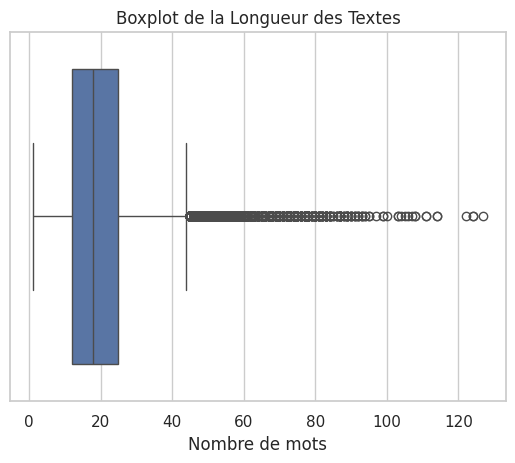

In [ ]:
#Visualisation de la distribution de la longueur des messages avec un boxplot
sns.boxplot(x=df['text_length'])
plt.title('Boxplot de la Longueur des Textes')
plt.xlabel('Nombre de mots')
plt.show()

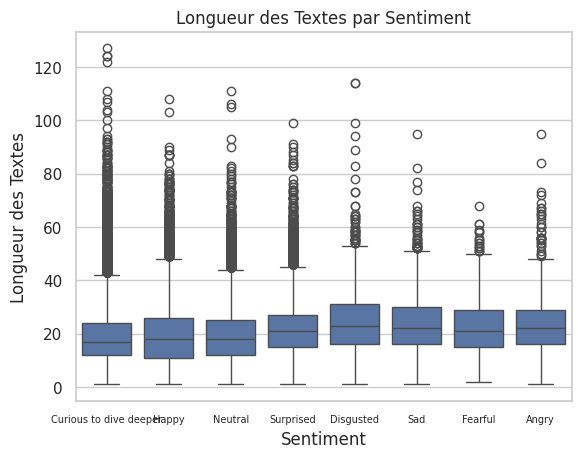

In [ ]:
# Observation des Distributions par Sentiment :
sns.boxplot(x='sentiment', y='text_length', data=df)
plt.title('Longueur des Textes par Sentiment')
plt.xlabel('Sentiment')
plt.xticks(fontsize=7)
plt.ylabel('Longueur des Textes')
plt.show()

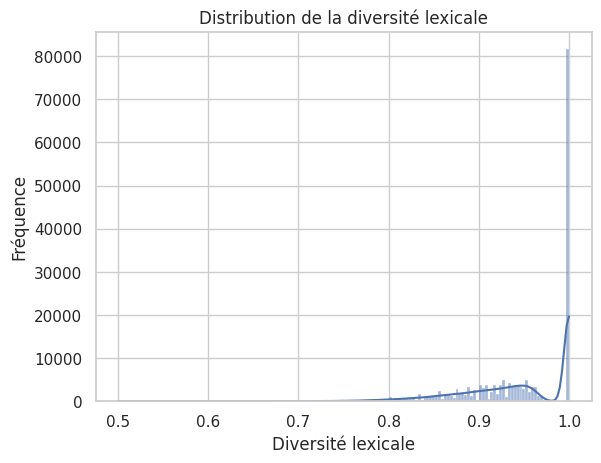

sentiment
Angry                     0.935459
Curious to dive deeper    0.949032
Disgusted                 0.930325
Fearful                   0.936522
Happy                     0.944385
Neutral                   0.943206
Sad                       0.930869
Surprised                 0.941494
Name: lexical_diversity, dtype: float64


In [ ]:
def lexical_diversity(text):
    words = text.split()
    return len(set(words)) / len(words) if len(words) > 0 else 0

df['lexical_diversity'] = df['message'].apply(lexical_diversity)
sns.histplot(df['lexical_diversity'], kde=True)
plt.title("Distribution de la diversité lexicale")
plt.xlabel("Diversité lexicale")
plt.ylabel("Fréquence")
plt.show()

# Moyenne par classe
print(df.groupby('sentiment')['lexical_diversity'].mean())

# **Analyse des stopwords**
 Un ratio élevé de stopwords peut signifier que les textes sont peu informatifs.

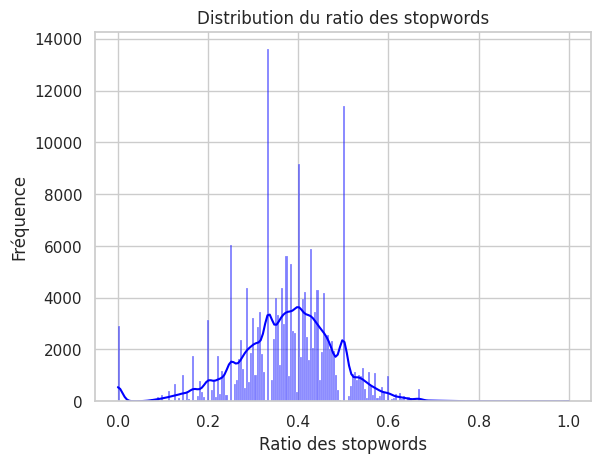

In [ ]:
# Définir la liste des stopwords
stop_words = set(stopwords.words('english'))

# Calculer le ratio des stopwords tout en gérant les cas où les textes sont vides
df['stopword_ratio'] = df['message'].apply(
    lambda x: len([word for word in x.split() if word in stop_words]) / len(x.split()) if len(x.split()) > 0 else 0
)

# Visualiser la distribution du ratio des stopwords
sns.histplot(df['stopword_ratio'], kde=True, color="blue")
plt.title("Distribution du ratio des stopwords")
plt.xlabel("Ratio des stopwords")
plt.ylabel("Fréquence")
plt.show()


In [ ]:
# # Liste des mots de négation
# negative_stopwords = ['not', 'no', 'none', 'neither', 'never', 'nobody', 'nothing', 'nowhere',
#                       "isn't", "aren't", "doesn't", "don't", "wasn't", "weren't", "didn't",
#                       "can't", "won't", "shouldn't", "wouldn't", "couldn't", "doesn't", "isn't"]

# # Liste des stopwords en anglais
# stop_words = set(stopwords.words('english'))

# # Combiner les stopwords classiques et ceux de la négation
# combined_stopwords = stop_words - set(negative_stopwords) # Exclure les mots de négation

In [ ]:
def preprocess_text(text):
    if isinstance(text, str):  # Vérifie si le texte est une chaîne
        text = text.lower()  # Convertir en minuscules
        text = re.sub(r'[^\w\s]', '', text)  # Supprimer les caractères spéciaux
        text = re.sub(r'\d+', '', text)  # Supprimer les chiffres
        tokens = text.split()  # Diviser en mots
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatisation et suppression des stopwords
        return ' '.join(tokens)  # Retourner le texte traité
    else:
        return ''  # Retourner une chaîne vide si ce n'est pas une chaîne



In [ ]:
data['cleaned_message'] = data['message'].apply(preprocess_text)

In [ ]:
# === Étape 2 : Gestion du déséquilibre des classes ===
# Encodage des labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['encoded_sentiment'] = label_encoder.fit_transform(data['sentiment'])

In [ ]:
# Sur-échantillonnage avec RandomOverSampler
ros = RandomOverSampler(random_state=42)
X = data['cleaned_message']
y = data['encoded_sentiment']
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)

In [ ]:
# Reconstruction du DataFrame
balanced_data = pd.DataFrame({'message': X_resampled.flatten(), 'sentiment': y_resampled})

In [ ]:
# === Étape 3 : Préparation des données pour TF-IDF ===
tfidf = TfidfVectorizer(max_features=10000)  # Limiter à 10k caractéristiques
X_tfidf = tfidf.fit_transform(balanced_data['message'])

In [ ]:
# Division en ensembles d'entraînement et de test
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, balanced_data['sentiment'], test_size=0.2, random_state=42, stratify=balanced_data['sentiment']
)

In [ ]:
# === Étape 4 : Préparation des données pour GloVe ===
# Tokenizer pour convertir les mots en indices
tokenizer = Tokenizer(num_words=20000)  # Limite à 20k mots
tokenizer.fit_on_texts(balanced_data['message'])
X_sequences = tokenizer.texts_to_sequences(balanced_data['message'])

In [ ]:
# Padding des séquences pour uniformiser la longueur
MAX_LEN = 100
X_padded = pad_sequences(X_sequences, maxlen=MAX_LEN, padding='post')

In [ ]:
# Division en ensembles d'entraînement et de test
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(
    X_padded, balanced_data['sentiment'], test_size=0.2, random_state=42, stratify=balanced_data['sentiment']
)

In [ ]:
# Encodage des labels en catégories pour GloVe
y_train_glove_cat = to_categorical(y_train_glove, num_classes=8)
y_test_glove_cat = to_categorical(y_test_glove, num_classes=8)

In [ ]:
# === Étape 5 : Chargement des embeddings GloVe ===
embedding_index = {}
with open('/content/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding_index[word] = np.array(values[1:], dtype='float32')

In [ ]:
# Création de la matrice d'embedding
VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [ ]:




# === Étape 6 : Construction du modèle CNN ===
# Entrée
input_layer = Input(shape=(MAX_LEN,))
embedding_layer = Embedding(
    VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False
)(input_layer)

# Convolution
conv3 = Conv1D(128, 3, activation='relu')(embedding_layer)
conv4 = Conv1D(128, 4, activation='relu')(embedding_layer)
conv5 = Conv1D(128, 5, activation='relu')(embedding_layer)

# Pooling
pool3 = GlobalMaxPooling1D()(conv3)
pool4 = GlobalMaxPooling1D()(conv4)
pool5 = GlobalMaxPooling1D()(conv5)

# Concatenation
concat = Concatenate()([pool3, pool4, pool5])

# Fully Connected
dense = Dense(128, activation='relu')(concat)
dropout = Dropout(0.5)(dense)

# Sortie
output_layer = Dense(8, activation='softmax')(dropout)

# Compilation
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Étape 7 : Entraînement ===
history = model.fit(
    X_train_glove, y_train_glove_cat,
    validation_data=(X_test_glove, y_test_glove_cat),
    epochs=10,
    batch_size=64
)




Epoch 1/10
8089/8089 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.4797 - loss: 1.3282 - val_accuracy: 0.6859 - val_loss: 0.7152
Epoch 2/10
8089/8089 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.6732 - loss: 0.7527 - val_accuracy: 0.6908 - val_loss: 0.7082
Epoch 3/10
8089/8089 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6906 - loss: 0.7083 - val_accuracy: 0.7105 - val_loss: 0.6601
Epoch 4/10
8089/8089 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.7008 - loss: 0.6860 - val_accuracy: 0.7150 - val_loss: 0.6495
Epoch 5/10
8089/8089 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7104 - loss: 0.6670 - val_accuracy: 0.7217 - val_loss: 0.6392
Epoch 6/10
8089/8089 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.7198 - loss: 0.6500 - val_accuracy: 0.7254 - val_loss: 0.6301
Epoch 7/10
8089/8089 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7284 - loss: 0.6326 - val_accuracy: 0.7321 - val_loss: 0.6235
Epoch 8/10
8089/8089 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.7367 - loss: 0

In [ ]:
# === Étape 8 : Évaluation ===
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test_glove)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_test_glove, y_pred_classes))
auc = roc_auc_score(y_test_glove_cat, y_pred, multi_class="ovr")
print(f"AUC-ROC: {auc}")

4045/4045 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     16177
           1       0.55      0.25      0.34     16177
           2       0.98      1.00      0.99     16178
           3       0.99      1.00      0.99     16178
           4       0.59      0.39      0.47     16178
           5       0.47      0.48      0.48     16177
           6       0.97      1.00      0.98     16178
           7       0.46      0.84      0.59     16177

    accuracy                           0.74    129420
   macro avg       0.75      0.74      0.73    129420
weighted avg       0.75      0.74      0.73    129420

AUC-ROC: 0.9452632003650581


In [ ]:
# Sauvegarde du modèle
model.save('mon_modele_cnn.h5')


In [ ]:
from tensorflow.keras.models import load_model

# Charger le modèle
model = load_model('mon_modele_cnn.h5')


In [ ]:
# Exemple de nouvelle phrase
new_sentence = "I am very happy with the service!"

# 1. Prétraitement du texte
processed_sentence = preprocess_text(new_sentence)

# 2. Conversion de la phrase en indices avec le tokenizer
new_sequence = tokenizer.texts_to_sequences([processed_sentence])

# 3. Padding de la séquence
new_padded_sequence = pad_sequences(new_sequence, maxlen=MAX_LEN, padding='post')

# 4. Prédiction du sentiment avec le modèle
predicted = model.predict(new_padded_sequence)

# 5. Conversion de la prédiction en une classe (label)
predicted_class = np.argmax(predicted, axis=1)

# 6. Décodage du label en sentiment
predicted_sentiment = label_encoder.inverse_transform(predicted_class)

# Affichage du résultat
print(f"Le sentiment de la phrase est : {predicted_sentiment[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Le sentiment de la phrase est : Happy


In [ ]:
# Exemple de nouvelle phrase
new_sentence = "i feel  sad today"

# 1. Prétraitement du texte
processed_sentence = preprocess_text(new_sentence)

# 2. Conversion de la phrase en indices avec le tokenizer
new_sequence = tokenizer.texts_to_sequences([processed_sentence])

# 3. Padding de la séquence
new_padded_sequence = pad_sequences(new_sequence, maxlen=MAX_LEN, padding='post')

# 4. Prédiction du sentiment avec le modèle
predicted = model.predict(new_padded_sequence)

# 5. Conversion de la prédiction en une classe (label)
predicted_class = np.argmax(predicted, axis=1)

# 6. Décodage du label en sentiment
predicted_sentiment = label_encoder.inverse_transform(predicted_class)

# Affichage du résultat
print(f"Le sentiment de la phrase est : {predicted_sentiment[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Le sentiment de la phrase est : Sad


In [ ]:
# Exemple de nouvelle phrase
new_sentence = "I am very disappointed with the service"

# 1. Prétraitement du texte
processed_sentence = preprocess_text(new_sentence)

# 2. Conversion de la phrase en indices avec le tokenizer
new_sequence = tokenizer.texts_to_sequences([processed_sentence])

# 3. Padding de la séquence
new_padded_sequence = pad_sequences(new_sequence, maxlen=MAX_LEN, padding='post')

# 4. Prédiction du sentiment avec le modèle
predicted = model.predict(new_padded_sequence)

# 5. Conversion de la prédiction en une classe (label)
predicted_class = np.argmax(predicted, axis=1)

# 6. Décodage du label en sentiment
predicted_sentiment = label_encoder.inverse_transform(predicted_class)

# Affichage du résultat
print(f"Le sentiment de la phrase est : {predicted_sentiment[0]}")

In [ ]:
# Exemple de nouvelle phrase
new_sentence = "Sure, waiting three weeks for delivery is totally fine"

# 1. Prétraitement du texte
processed_sentence = preprocess_text(new_sentence)

# 2. Conversion de la phrase en indices avec le tokenizer
new_sequence = tokenizer.texts_to_sequences([processed_sentence])

# 3. Padding de la séquence
new_padded_sequence = pad_sequences(new_sequence, maxlen=MAX_LEN, padding='post')

# 4. Prédiction du sentiment avec le modèle
predicted = model.predict(new_padded_sequence)

# 5. Conversion de la prédiction en une classe (label)
predicted_class = np.argmax(predicted, axis=1)

# 6. Décodage du label en sentiment
predicted_sentiment = label_encoder.inverse_transform(predicted_class)

# Affichage du résultat
print(f"Le sentiment de la phrase est : {predicted_sentiment[0]}")




In [ ]:

new_sentence ="the more I felt an insatiable curiosity, a desire to explore the unknown and uncover the hidden truths that have long fascinated humanity"
# 1. Prétraitement du texte
processed_sentence = preprocess_text(new_sentence)

# 2. Conversion de la phrase en indices avec le tokenizer
new_sequence = tokenizer.texts_to_sequences([processed_sentence])

# 3. Padding de la séquence
new_padded_sequence = pad_sequences(new_sequence, maxlen=MAX_LEN, padding='post')

# 4. Prédiction du sentiment avec le modèle
predicted = model.predict(new_padded_sequence)

# 5. Conversion de la prédiction en une classe (label)
predicted_class = np.argmax(predicted, axis=1)

# 6. Décodage du label en sentiment
predicted_sentiment = label_encoder.inverse_transform(predicted_class)

# Affichage du résultat
print(f"Le sentiment de la phrase est : {predicted_sentiment[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Le sentiment de la phrase est : Neutral
